In [4]:
import torch
import torchaudio
import os
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, AutoModel
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

# Load Whisper
from transformers import WhisperProcessor, WhisperModel
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperModel.from_pretrained("openai/whisper-small").to("cuda")
model.eval()

print("Model loaded")

# Dataset class
class WhisperDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.labels = []
        self.label_encoder = LabelEncoder()
        
        for label in sorted(os.listdir(root_dir)):
            label_path = os.path.join(root_dir, label)
            for file in os.listdir(label_path):
                if file.endswith(".wav"):
                    self.samples.append(os.path.join(label_path, file))
                    self.labels.append(label)
        
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        filepath = self.samples[idx]
        label = self.encoded_labels[idx]
        audio, sr = torchaudio.load(filepath)
        audio = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(audio)
        input_features = processor(audio.squeeze().numpy(), sampling_rate=16000, return_tensors="pt").input_features.to(device)
    
        with torch.no_grad():
            # 🔥 Only the encoder is used here
            features = model.encoder(input_features).last_hidden_state.squeeze(0)
    
        return features, torch.tensor(label, dtype=torch.long)


# BiLSTM Classifier
# Updated BiLSTM Classifier with input_dim=768
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, output_dim=4):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = torch.cat((hn[-2], hn[-1]), dim=1)  # Concatenate the last hidden states from both directions
        return self.fc(out)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = WhisperDataset("/kaggle/input/class-data/class-data")
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # batch_size=1 due to variable length

# print("data loaded", len(dataset[0]), dataloader.shape)

model_classifier = BiLSTMClassifier(input_dim=768, output_dim=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_classifier.parameters(), lr=1e-4)

Model loaded


In [5]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [6]:
def compute_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [7]:
from tqdm import tqdm

print("Training")

for epoch in range(10):
    model_classifier.train()
    running_loss = 0.0
    correct, total = 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for features, labels in loop:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Training accuracy per batch
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    val_acc = compute_accuracy(model_classifier, val_loader)

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Training


Epoch 1: 100%|██████████| 9149/9149 [29:25<00:00,  5.18it/s, loss=0.00227] 


Epoch 1, Loss: 0.3645, Train Acc: 0.8614, Val Acc: 0.9401


Epoch 2: 100%|██████████| 9149/9149 [27:59<00:00,  5.45it/s, loss=0.00169] 


Epoch 2, Loss: 0.1091, Train Acc: 0.9636, Val Acc: 0.9642


Epoch 3: 100%|██████████| 9149/9149 [28:09<00:00,  5.42it/s, loss=0.000146]


Epoch 3, Loss: 0.0632, Train Acc: 0.9779, Val Acc: 0.9615


Epoch 4: 100%|██████████| 9149/9149 [28:24<00:00,  5.37it/s, loss=0.000687]


Epoch 4, Loss: 0.0408, Train Acc: 0.9852, Val Acc: 0.9633


Epoch 5: 100%|██████████| 9149/9149 [28:23<00:00,  5.37it/s, loss=0.00116] 


Epoch 5, Loss: 0.0272, Train Acc: 0.9904, Val Acc: 0.9760


Epoch 6: 100%|██████████| 9149/9149 [28:09<00:00,  5.41it/s, loss=3.78e-5] 


Epoch 6, Loss: 0.0276, Train Acc: 0.9916, Val Acc: 0.8851


Epoch 7: 100%|██████████| 9149/9149 [28:21<00:00,  5.38it/s, loss=0.00175] 


Epoch 7, Loss: 0.0153, Train Acc: 0.9953, Val Acc: 0.9624


Epoch 8: 100%|██████████| 9149/9149 [28:15<00:00,  5.40it/s, loss=0.0026]  


Epoch 8, Loss: 0.0174, Train Acc: 0.9939, Val Acc: 0.9677


Epoch 9: 100%|██████████| 9149/9149 [28:04<00:00,  5.43it/s, loss=0.000709]


Epoch 9, Loss: 0.0095, Train Acc: 0.9976, Val Acc: 0.9799


Epoch 10: 100%|██████████| 9149/9149 [28:01<00:00,  5.44it/s, loss=9.54e-6] 


Epoch 10, Loss: 0.0103, Train Acc: 0.9968, Val Acc: 0.9663


In [10]:
# Save model after final epoch
torch.save(model_classifier.state_dict(), "best_model.pth")
print("✅ Model saved as best_model.pth")

✅ Model saved as best_model.pth


<ipython-input-12-b2ca9247d33f>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_classifier.load_state_dict(torch.load("best_model.pth"))
Evaluating on Test Set: 100%|


✅ Test Accuracy: 96.63%

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9532    0.9899    0.9712       597
           1     0.9871    0.9274    0.9563       496
           2     0.9885    0.9348    0.9609       460
           3     0.9518    0.9932    0.9720       735

    accuracy                         0.9663      2288
   macro avg     0.9702    0.9613    0.9651      2288
weighted avg     0.9672    0.9663    0.9662      2288



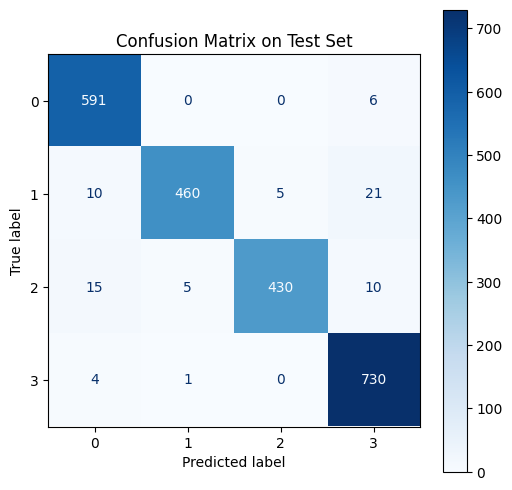

In [12]:
from tqdm import tqdm
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Load best model
model_classifier.load_state_dict(torch.load("best_model.pth"))
model_classifier.to(device)
model_classifier.eval()

# Store predictions and labels
y_true = []
y_pred = []

# Run inference with tqdm
with torch.no_grad():
    loop = tqdm(val_loader, desc="Evaluating on Test Set")
    for features, labels in loop:
        features, labels = features.to(device), labels.to(device)
        outputs = model_classifier(features)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ✅ Test Accuracy
test_accuracy = np.mean(y_true == y_pred)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")

# 📊 Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title("Confusion Matrix on Test Set")
plt.show()

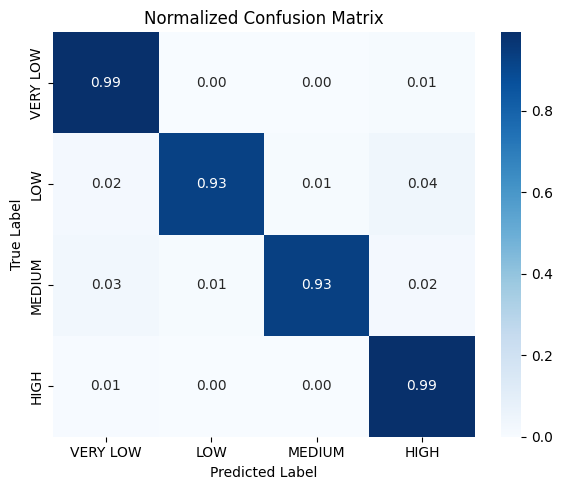

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Normalize confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

class_names = ["VERY LOW","LOW","MEDIUM","HIGH"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", cbar=True,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

t-SNE feature extraction: 100%|██████████| 2288/2288 [05:50<00:00,  6.53it/s]


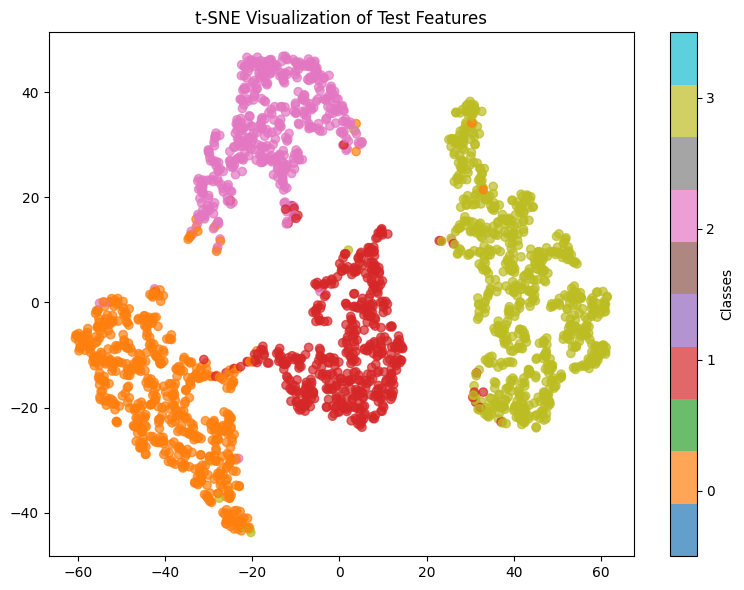

In [16]:
from sklearn.manifold import TSNE
import torch
import numpy as np
import matplotlib.pyplot as plt

model_classifier.eval()
features_list = []
labels_list = []

with torch.no_grad():
    loop = tqdm(val_loader, desc="t-SNE feature extraction")
    for inputs, labels in loop:
        inputs = inputs.to(device)
        labels = labels.to(device)
        feats = model_classifier(inputs)  # This assumes you're getting the final layer features
        features_list.append(feats.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

# Stack features and labels
features_array = np.vstack(features_list)
labels_array = np.array(labels_list)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(features_array)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_array, cmap='tab10', alpha=0.7)
plt.title("t-SNE Visualization of Test Features")
plt.colorbar(scatter, ticks=np.arange(len(class_names)), label="Classes")
plt.clim(-0.5, len(class_names)-0.5)
plt.tight_layout()
plt.show()